# Исследование надежности заемщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.


**Описание данных**
- **children** — количество детей в семье
- **days_employed** — общий трудовой стаж в днях
- **dob_years** — возраст клиента в годах
- **education** — уровень образования клиента
- **education_id** — идентификатор уровня образования
- **family_status** — семейное положение
- **family_status_id** — идентификатор семейного положения
- **gender** — пол клиента
- **income_type** — тип занятости
- **debt** — имел ли задолженность по возврату кредитов
- **total_income** — ежемесячный доход
- **purpose** — цель получения кредита

**План проекта**
1. Загрузка даных
2. Предобработка данных
3. Исследование данных
4. Общий вывод

## Загрузка даных

### Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [3]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Предварительно можно отметить следующее:
- В данных имеются пропуски в столбцах days_employed и total_income.
- В столбце days_employed присутствуют аномальные отрицательные значения.
- Необходимо изменить тип данных столбца total_income на integer.

## Предобработка данных

### Удаление пропусков

In [5]:
# количество пропущенных значений для каждого столбца
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В двух столбцах есть пропущенные значения:

* days_employed - общий трудовой стаж в днях. Пропуски в данном столбце будут обработаны на следующем этапе.

* total_income —  данные о доходах. На сумму дохода сильнее всего влияет тип занятости. Пропуски в этом столбце будут заполнены медианными значениями по каждому типу из столбца income_type.

In [6]:
# заполнение пропусков
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

In [7]:
# проверка
data['income_type'].isna().sum()

0

### Обработка аномальных значений

Необходимо обработать аномалии в данных, связанные со столбцом days_employed. В данном столбце могут встречаться отрицательные значения, которые не отражают действительность и возникли из-за ошибок. Для корректной обработки данных следует заменить все отрицательные значения на положительные

In [8]:
# замена отрицательных значений положительными
data['days_employed'] = data['days_employed'].abs()

In [9]:
# медианное значение трудового стажа days_employed в днях lля каждого типа занятости
data.groupby('income_type')['days_employed'].agg('median').round(2)

income_type
безработный        366413.65
в декрете            3296.76
госслужащий          2689.37
компаньон            1547.38
пенсионер          365213.31
предприниматель       520.85
сотрудник            1574.20
студент               578.75
Name: days_employed, dtype: float64

In [10]:
# уникальные значений столбца children
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

В столбце children есть два аномальных значения: -1 и 20

In [11]:
# удаление строк с аномальнаыми значениями
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [12]:
# проверка
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

In [13]:
# заполнение пропусков в столбце days_employed медианными значениями по каждого типа занятости income_type
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [14]:
# проверка
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

In [15]:
#  Изменение типа данных в столбце на целочисленный
data['total_income'] = data['total_income'].astype('int64')

In [16]:
# проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21402 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21402 non-null  int64  
 1   days_employed     21402 non-null  float64
 2   dob_years         21402 non-null  int64  
 3   education         21402 non-null  object 
 4   education_id      21402 non-null  int64  
 5   family_status     21402 non-null  object 
 6   family_status_id  21402 non-null  int64  
 7   gender            21402 non-null  object 
 8   income_type       21402 non-null  object 
 9   debt              21402 non-null  int64  
 10  total_income      21402 non-null  int64  
 11  purpose           21402 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.1+ MB


### Обработка дубликатов

In [17]:
# проверка на неявные дубликаты
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [18]:
# обработка дубликатов
data['education'] = data['education'].str.lower()

In [19]:
# количество строк-дубликатов в данных
data.duplicated().sum()

71

In [20]:
# удаление дубликатов
data = data.drop_duplicates()

### Категоризация данных

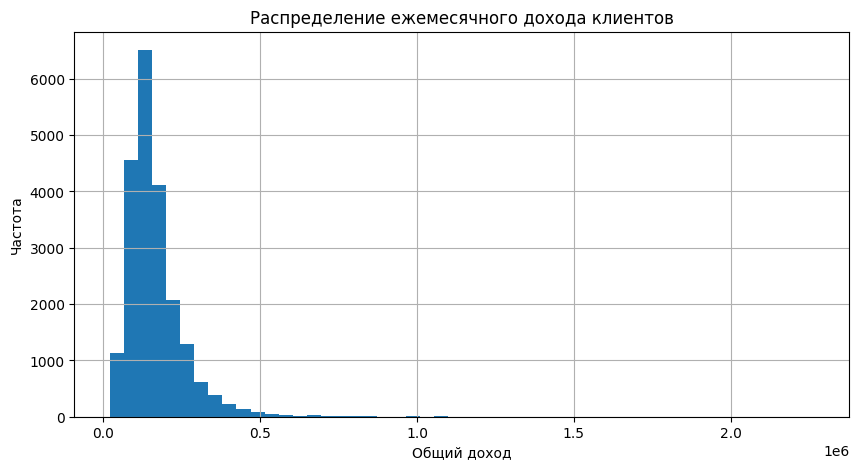

In [21]:
# построение графика
data['total_income'].hist(bins=50, figsize=(10, 5))
plt.title('Распределение ежемесячного дохода клиентов')
plt.xlabel('Общий доход')
plt.ylabel('Частота')
plt.show()

В распределении ежемесячных доходов клиентов выделяется значительный правый хвост, что подчеркивает характерное свойство денежных средств: у небольшой группы клиентов доходы существенно превышают доходы большинства.

Создание дополнительного столбца `total_income_category` с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [22]:
def categorize_floor(floor):
    # Функция для категоризации уровня дохода по заданным диапазонам
    try:
        if 0 <= floor <= 30000:
            return 'E'
        elif 30001 <= floor <= 50000:
            return 'D'
        elif 50001 <= floor <= 200000:
            return 'C'
        elif 200001 <= floor <= 1000000:
            return 'B'
        elif floor >= 1000001:
            return 'A'
    except:
        return None  # Возврат None в случае ошибки

# Применение функции categorize_floor для создания новой категории дохода на основе общего дохода
data['total_income_category'] = data['total_income'].apply(categorize_floor)

In [23]:
#перечень уникальных целей взятия кредита
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создание функции, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [24]:
def categorize_purpose(row):
    # Функция для категоризации целей кредита по ключевым словам
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [25]:
# Применение функции
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

### Исследование данных

#### Анализ зависимости между количеством детей и возвратом кредита в срок

In [26]:
#зависимость среднего значение задолжников от кол-ва детей
ch_debt=data.pivot_table(index='children', values='debt', aggfunc=['count', 'mean', 'sum']).reset_index().droplevel(1, axis=1)
ch_debt['mean'] = ch_debt['mean']*100 #переводим значение задолжников в проценты
ch_debt #выводим таблицу

,children,count,mean,sum
0,0,14091,7.543822,1063
1,1,4808,9.234609,444
2,2,2052,9.454191,194
3,3,330,8.181818,27
4,4,41,9.756098,4
5,5,9,0.000000,0


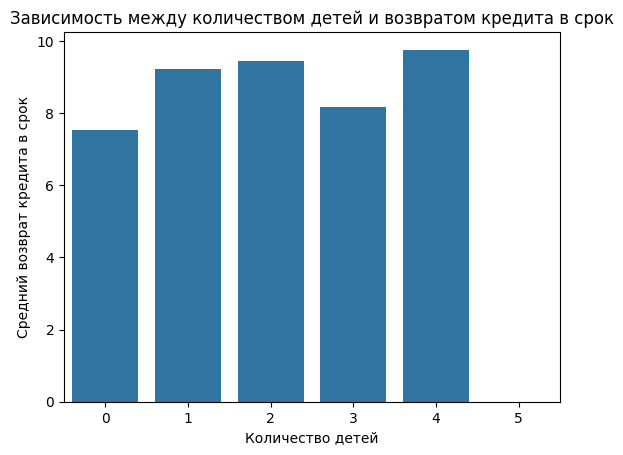

In [27]:
# Создание графика
sns.barplot(x='children', y='mean', data=ch_debt).set(title='Зависимость между количеством детей и возвратом кредита в срок')

# Установка меток осей
plt.xlabel('Количество детей')
plt.ylabel('Средний возврат кредита в срок')

# Отображение графика
plt.show()

Выборка не сбалансированна: клиентов с 3-5 детьми слишком мало, чтобы делать какие-либо выводы. 

In [28]:
a = ch_debt.loc[1:2, 'mean'].mean() #среднее значение задолжников для людей с детьми, берем лишь для 1-2 детей, т.к. кол-во данных больше и вывод будет точнее
b = ch_debt.loc[0, 'mean'] #среднее значение задолжников для людей без детей
print('Процент различия факта возврата кредита клиентами без детей и клинтами с 1-2 детьми:', (a - b).round(2)) #процент различия задолжников

Процент различия факта возврата кредита клиентами без детей и клинтами с 1-2 детьми: 1.8


Вероятность возвращения клиентом кредита в срок при наличие 1-2 детей уменьшается на 1,8%

**Вывод:** 
-  Люди без детей берут кредит чаще. Вероятность возвращения клиентом кредита в срок при наличие детей уменьшается в среднем на **1,8%**.

-  Люди, которые не имеют детей, лучше всего отдают кредит, доля должников здесь составляет с **7,5%**, хуже обстоит дело с кредиторами, кто имеет одного или двух детей, здесь доля невозврата составляет соответственно **9,2% и 9,4%**. 
-  Остальные категории уже некорректно сравнивать, так как среди них очень маленькая выборка

#### Анализ зависимости между семейным положением и возвратом кредита в срок

In [29]:
#создаю таблицу зависимости семейного положения от возврата кредита в срок
family_debt=data.pivot_table(index='family_status', values='debt', aggfunc=['count', 'mean', 'sum']).reset_index().droplevel(1, axis=1).sort_values('mean')
family_debt['mean'] = family_debt['mean']*100 #перевожу среднее значение debt в проценты для удобства просмотра результатов
family_debt #вывожу таблицу

,family_status,count,mean,sum
2,вдовец / вдова,951,6.624606,63
1,в разводе,1189,7.064760,84
4,женат / замужем,12261,7.560558,927
3,гражданский брак,4134,9.313014,385
0,Не женат / не замужем,2796,9.763948,273


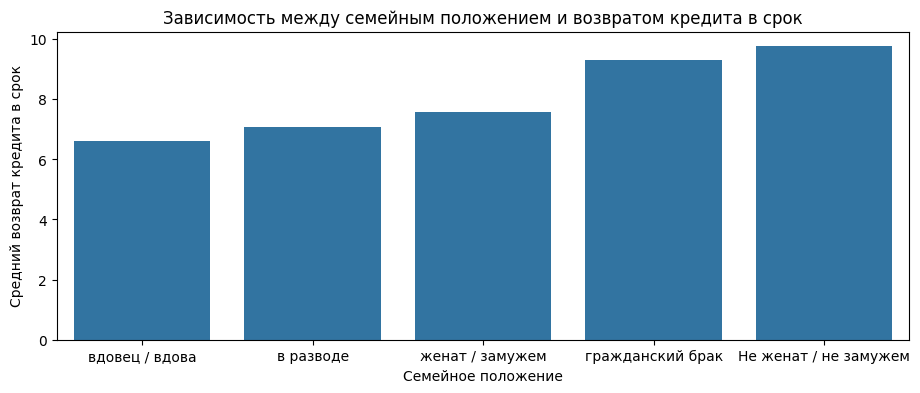

In [30]:
# Создание графика
fig, ax = plt.subplots(figsize=(11, 4))
sns.barplot(x="family_status", y='mean', data=family_debt, ax=ax, err_kws={'linewidth': 0}).set(title='Зависимость между семейным положением и возвратом кредита в срок')

# Установка меток осей
plt.xlabel('Семейное положение')
plt.ylabel('Средний возврат кредита в срок')

# Отображение графика
plt.show()

Зачастую в кредите нуждаются люди в браке, но в срок возвращают чаще вдовцы и те, кто в разведе.
Посмотрю, есть ли взаимосвязь между целью взятия кредита и семейным статусом клиента.

**Частота взятия кредита от семейного статуса и цели**

In [31]:
family_purpose_debt = data.groupby(['family_status','purpose_category']).agg({'purpose':'count'}).reset_index()
family_purpose_debt
pd.pivot_table(
   data=family_purpose_debt,
   index='purpose_category',
   columns='family_status',
   )

purpose                           \
family_status            Не женат / не замужем в разводе вдовец / вдова   
purpose_category                                                          
операции с автомобилем                   635.0     279.0          218.0   
операции с недвижимостью                1586.0     672.0          535.0   
получение образования                    575.0     238.0          198.0   
проведение свадьбы                         NaN       NaN            NaN   

                                                           
family_status            гражданский брак женат / замужем  
purpose_category                                           
операции с автомобилем              430.0          2717.0  
операции с недвижимостью            988.0          6970.0  
получение образования               403.0          2574.0  
проведение свадьбы                 2313.0             NaN

Наибольшие суммы кредитов наблюдаются у семейных клиентов (женат/замужем) для операций с недвижимостью и свадьбами. Люди в гражданском браке также имеют значительные суммы по всем категориям, тогда как неженатые и вдовы/вдовцы имеют значительно меньшие суммы, особенно для проведения свадьбы, где данные отсутствуют.

**Среднее значение возврата кредита в зависимости от семейного статуса и цели**

In [32]:
pd.pivot_table(
    data=data,
    index='purpose_category',
    columns='family_status',
    values='debt',
    aggfunc='mean').round(2)

family_status,Не женат / не замужем,в разводе,вдовец / вдова,гражданский брак,женат / замужем
purpose_category,,,,,
операции с автомобилем,0.13,0.08,0.09,0.12,0.08
операции с недвижимостью,0.08,0.07,0.05,0.09,0.07
получение образования,0.11,0.07,0.08,0.15,0.08
проведение свадьбы,NaN,NaN,NaN,0.08,NaN


В таблице представлены доли клиентов, которые вернули кредиты в срок, разбитые по категориям целей и семейному положению. Наивысшие показатели наблюдаются у людей, получающих образование в группе "гражданский брак". Люди в статусе "Не женат / не замужем" имеют относительно высокие доли по всем категориям, особенно для операций с автомобилем. В то же время, данные по проведению свадьбы отсутствуют для всех категорий, что указывает на низкую или отсутствующую кредитную активность в этой области.

In [33]:
family_children = data.groupby(['family_status','children']).agg({'debt':'mean'}).reset_index()
family_children
pd.pivot_table(
   data=family_children,
   index='children',
   columns='family_status',
   ).round(2)

debt                                            \
family_status Не женат / не замужем в разводе вдовец / вдова гражданский брак   
children                                                                        
0                              0.09      0.07           0.06             0.08   
1                              0.12      0.07           0.09             0.12   
2                              0.12      0.09           0.15             0.09   
3                              0.12      0.09           0.00             0.14   
4                              0.50      0.00           0.00             0.00   
5                               NaN       NaN            NaN             0.00   

                               
family_status женат / замужем  
children                       
0                        0.07  
1                        0.08  
2                        0.09  
3                        0.07  
4                        0.10  
5                        0.00

В таблице представлены доли клиентов с задолженностью по кредитам, разбитые по количеству детей и семейному положению. Наибольшие доли задолженности наблюдаются у клиентов с тремя детьми, особенно среди тех, кто неженат / не замужем. Для клиентов с четырьмя детьми уровень задолженности достигает 50% в группе "Не женат / не замужем". В то же время, для семей с детьми в статусе "женат / замужем" показатели задолженности остаются ниже, особенно для тех, у кого нет детей. Данные для клиентов с пятью детьми отсутствуют или равны нулю, что указывает на низкую активность в этой группе.

In [34]:
num_widowers = family_debt.loc[2, 'count']  # количество вдовцов в выборке
num_divorcees = family_debt.loc[1, 'count']  # количество людей в разводе в выборке
total_clients = family_debt.loc[:, 'count'].sum()  # общее количество клиентов
percent_widowers = num_widowers / total_clients * 100  # процент вдовцов в выборке
percent_divorcees = num_divorcees / total_clients * 100  # процент людей в разводе в выборке

print('Процент вдовцов в выборке:', percent_widowers.round(1))
print('Процент людей в разводе в выборке:', percent_divorcees.round(1))

Процент вдовцов в выборке: 4.5
Процент людей в разводе в выборке: 5.6


**Вывод** 
-  В среднем вдовцы, люди в разводе и женатые отдают кредит лучше - доля невозврата соответственно **6,6%, 7% и 7.5%** 
Люди, находящиеся в гражданском браке и неженатые отдают кредит хуже - доля невозврата соответственно **9.3% и 9.8%** 

-  Если же рассмотреть взаимосвязь семейного статуса и количества имеющихся у клиентов детей, - заметно, что отсутствие детей улучшает показатели возврата кредита. К примеру, доля невозврата женатых людей, как написано выше, - **7,5%** , доля невозврата женатых людей без детей уже **6.9%**.

-  Люди, вне зависимости от семейного положения, чаще берут кредит на операции с недвижимостью и операции с автомобилем. 
За исключением тех, кто находится в гражданском браке: для них основная цель кредита - свадьба, и кредит на свадьбу они возвращают лучше, чем по другим целям. 

-  **Показатели по вдовцам и людям в разводе могут быть неточными, так как их доля в выборке составляет 4.5% и 5.6% соответственно.**  


#### Анализ зависимости между уровнем дохода и возвратом кредита в срок

In [35]:
# Создание сводной таблицы для анализа задолженности по категориям дохода
income_debt = data.pivot_table(index='total_income_category', values='debt', aggfunc=['count', 'mean', 'sum'])\
    .reset_index()\
    .droplevel(1, axis=1)\
    .sort_values('mean')  # Сортировка по среднему значению задолженности

# Перевод среднего значения задолженности в проценты для удобства анализа
income_debt['mean'] = (income_debt['mean'] * 100 ).round(1)

# Вывод таблицы с результатами
income_debt

,total_income_category,count,mean,sum
3,D,349,6.0,21
1,B,5014,7.1,354
0,A,25,8.0,2
2,C,15921,8.5,1353
4,E,22,9.1,2


Описание категорий:
* 0–30000 — 'E';
* 30001–50000 — 'D';
* 50001–200000 — 'C';
* 200001–1000000 — 'B';
* 1000001 и выше — 'A'.

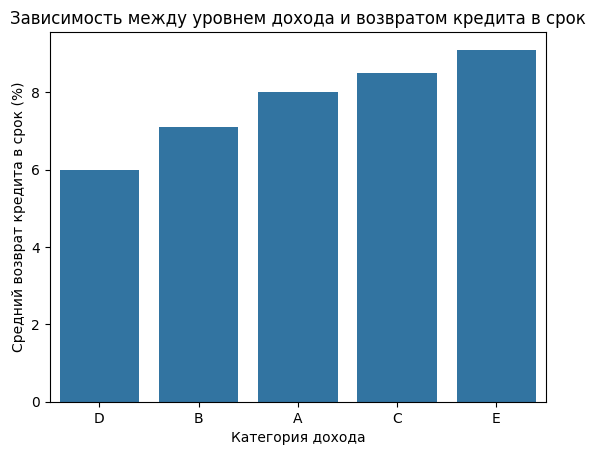

In [36]:
# Построение столбчатой диаграммы зависимости между уровнем дохода и возвратом кредита в срок
sns.barplot(x='total_income_category', y='mean', data=income_debt).set(title='Зависимость между уровнем дохода и возвратом кредита в срок')

# Установка меток осей
plt.xlabel('Категория дохода')
plt.ylabel('Средний возврат кредита в срок (%)')

# Отображение графика
plt.show()

In [37]:
# Получение количества людей в каждой категории дохода из сводной таблицы
category_a_count = income_debt.loc[0, 'count']  # количество людей категории A в выборке
category_d_count = income_debt.loc[3, 'count']  # количество людей категории D в выборке
category_e_count = income_debt.loc[4, 'count']  # количество людей категории E в выборке
category_c_count = income_debt.loc[2, 'count']  # количество людей категории C в выборке

# Вычисление процентов для каждой категории
pr_category_a = round(category_a_count / total_clients * 100, 1)  # процент категории A в выборке
pr_category_d = round(category_d_count / total_clients * 100, 1)  # процент категории D в выборке
pr_category_e = round(category_e_count / total_clients * 100, 1)  # процент категории E в выборке
pr_category_c = round(category_c_count / total_clients * 100, 1)  # процент категории C в выборке

# Вывод результатов
print('Процент количества людей категории A в выборке:', pr_category_a)
print('Процент количества людей категории D в выборке:', pr_category_d)
print('Процент количества людей категории E в выборке:', pr_category_e)
print('Процент количества людей категории C в выборке:', pr_category_c)

Процент количества людей категории A в выборке: 0.1
Процент количества людей категории D в выборке: 1.6
Процент количества людей категории E в выборке: 0.1
Процент количества людей категории C в выборке: 74.6


**Вывод:** 
-  Клиентов с категориями A,D,E - слишком мало, чтобы делать какие-то выводы, процент количества людей данных категорий в выборке соответсвенно: **0.1%, 1.6%, 0.1%**. 

-  Если сравнивать только клиентов категории В и С, лучше возвращают кредит люди с доходом категории В (диапозоне 200001–1000000) - доля невозврата **7.1%**. 

-  Большинство клиентов банка  - люди с доходом категорий 'C'(в диапозоне 50001–200000), это 74% всех клиентов, доля невозврата среди них **8.5%**.

#### Анализ влияния различных целей кредита на его возврат в срок

In [38]:
# Создание сводной таблицы для анализа задолженности по категориям целей кредита
purpose_debt = data.pivot_table(index='purpose_category', values='debt', aggfunc=['count', 'mean', 'sum'])\
    .reset_index()\
    .droplevel(1, axis=1)\
    .sort_values('mean')  # Сортировка по среднему значению задолженности

# Перевод среднего значения задолженности в проценты для удобства анализа
purpose_debt['mean'] = purpose_debt['mean'] * 100  

# Вывод таблицы с результатами
purpose_debt

,purpose_category,count,mean,sum
1,операции с недвижимостью,10751,7.255139,780
3,проведение свадьбы,2313,7.911803,183
2,получение образования,3988,9.252758,369
0,операции с автомобилем,4279,9.347978,400


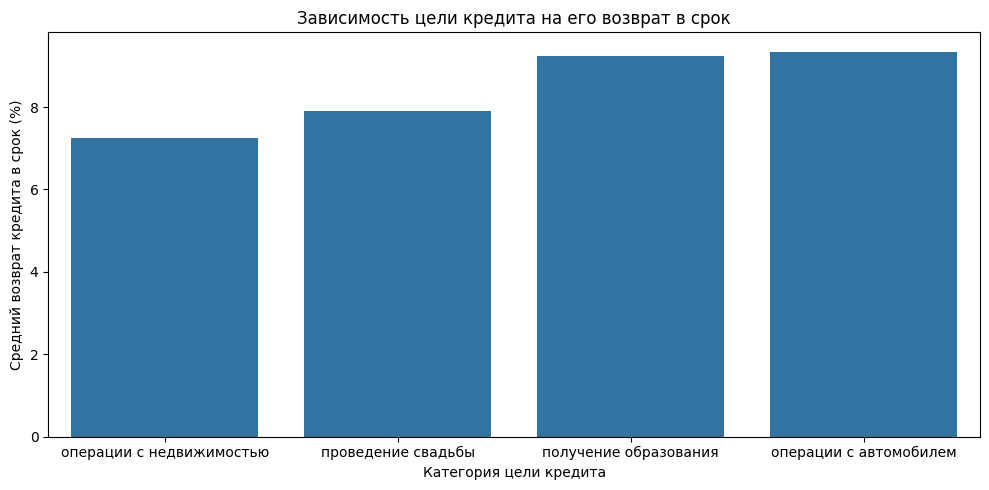

In [39]:
# Построение столбчатой диаграммы зависимости целей кредита от его возврата в срок
fig, ax = plt.subplots(figsize=(10, 5))  

# Создание графика
sns.barplot(x='purpose_category', y='mean', data=purpose_debt).set(title='Зависимость цели кредита на его возврат в срок')

# Установка меток осей
plt.xlabel('Категория цели кредита')
plt.ylabel('Средний возврат кредита в срок (%)')

# Отображение графика
plt.tight_layout()  
plt.show()

**Вывод:** Клиенты, цель которых являются операции с недвижимостью - возвращают кредит лучше остальных: доля невозврата **7,3%**.
Также хорошие показатели у клиентов, которые берут кредит на свадьбу, доля невозврата **7,9%**.
Хуже с такими целями как: получание образования и операции с автомобилем, доля невозврата по **9.3%**.

Вероятно, кредит на операции с недвижимостью возвращают лучше, так как требования к заемщикам выше. В свою очередь заемщики, возможно, относятся к данной цели с большей ответсвенностью из-за крупной суммы кредита.

#### Возможные причины возникновения пропусков в исходных данных

Пропуски в столбце с доходами вероятно из-за того, что при определенных условиях банк выдает кредит без подтверждения дохода. 
Так как количество пропусков в столбце трудового стажа совпадает с пропусками в столбце доходов, ситауция аналогичная: если нет необходимости подтвержать доход, то и информация по трудовому стажу не имеет значения. 


Но скорее всего ошибка носит технический характер. Чтобы узнать точную причину - лучше обратиться к ответсвенным за исходные данные. 

#### Объяснение, почему заполнение пропусков медианным значением является лучшим решением для количественных переменных.

Распределение Парето - является степенным распределением вероятностей, которое используется при описании многих типов наблюдаемых явлений. Принцип Парето или "правило 80-20", утверждающий, что 80% результатов обусловлены 20% причин. 

Соблюдение принципа 80/20 очень часто встречается в самых разных областях. Например, во многие времена во многих сообществах оказывалось, что 20 % людей обладают 80 % капитала, в бизнесе зачастую 20 % покупателей или постоянных клиентов приносят 80 % прибыли. Но в этих утверждениях фундаментальными являются не приведённые числовые значения, а сам факт их существенного различия, конкретные цифры степени неравномерности могут быть любыми.

Так как распределение количественных переменных обычно неравномерно, то среднее значение - покажет ложный результат, именно поэтому нужно брать медианное значение. 

### Общий вывод.

-  Клиенты без детей в среднем на 1,8% чаще возвращают кредит в срок.
-  Клиенты в браке в среднем на 2% чаще возвращают кредит в срок, чем неженатые и находящиеся в гражданском браке.
-  Клиенты с доходом категории В (в диапазоне 200001–1000000) в среднем чаще возвращают кредит в срок - доля невозврата среди них 7.1%
-  Клиенты, цель которых являются операции с недвижимостью - в среднем возвращают кредит лучше остальных: доля невозврата 7,3%


- В данных присутствует большое количество пропусков в столбцах с доходом и трудовым стажем, что влияет на точность конечных результатов анализа. Также в столбце с трудовым стажем присутствуют аномально большие значения у безработных и пенсионеров. Следует обратить внимание на качество сбора этих данных.  
- Можно было бы добиться более точных результатов анализа, если бы для различных 'редких' категорий клиентов (клиенты с 3-5 детьми, клиенты с доходами категорий A,D,E; клиенты в разводе/вдовцы) - было бы специально подобранно примерно одинаковое количество данных для выборки в сравнении с более "популярными" категориями. 